#  DSC530-T304 Data Exploration and Analysis - Week 11 #

## Survival  Analysis ##

### Excercise Chapter 13 ###
------

In [1]:
# Download pregency and respondent data files from thinkstat

from os.path import basename, exists

# Declare a function to download the files to local
def download(fileurl):
    filename = basename(fileurl)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(fileurl, filename)
        print("Downloaded " + local)

In [2]:
# survival.py

# Dowload the python and data files to load pregnency and respondent data 
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/survival.py")


In [3]:
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz"
)
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemResp.dct")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemResp.dat.gz")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")

In [4]:
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/1995FemRespData.dat.gz"
)
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2006_2010_FemRespSetup.dct"
)
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2006_2010_FemResp.dat.gz"
)

In [5]:
import nsfg
#Load the Pregnancy data
preg_df = nsfg.ReadFemPreg()

**Exercise 13.1**<BR>   
In NSFG Cycles 6 and 7, the variable cmdivorcx contains the date of divorce for the respondent’s first marriage, if applicable, encoded in century-months.
Compute the duration of marriages that have ended in divorce, and the duration, so far, of marriages that are ongoing. Estimate the hazard and survival curve for the duration of marriage.

Use resampling to take into account sampling weights, and plot data from several resamples to visualize sampling error.

Consider dividing the respondents into groups by decade of birth, and possibly by age at first marriage.


**List of attributes that will help to determine age,  duration of marriage,  duration of survival etc**** 
cmbirth: The respondent’s date of birth, known for all respondents.

cmintvw: The date the respondent was interviewed, known for all respondents.

cmmarrhx: The date the respondent was first married, if applicable and known.

evrmarry: 1 if the respondent had been married prior to the date of interview, 0 otherwise.

Steps
- create a list of divorced list

- Create a list of married but divorce status not known or not divorced

- Create a hazard function

- Predict values for latst decades as the age is less while interviewed 

In [6]:
# Dowload all year data to load them for hazard function and group by decade

import survival

# Download respective cycle data 
resp_cyc6 = survival.ReadFemResp2002()
resp_cyc7 = survival.ReadFemResp2010()

In [7]:
# define color codes
colors = ['b','g','r','c','m','y']

In [8]:
# clean the data and add the duration between marriage and divorce,  duration ebtween mariage and interview,  
# and add the decade value to each record
def CleanDataAndAddDivorceDurationAttributes(resp):
    resp.cmdivorcx.replace([9998, 9999], np.nan, inplace=True)

    resp["notdivorced"] = resp.cmdivorcx.isnull().astype(int)
    resp["duration"] = (resp.cmdivorcx - resp.cmmarrhx) / 12.0
    resp["durationsofar"] = (resp.cmintvw - resp.cmmarrhx) / 12.0

    month0 = pd.to_datetime("1899-12-15")
    dates = [month0 + pd.DateOffset(months=cm) for cm in resp.cmbirth]
    resp["decade"] = (pd.DatetimeIndex(dates).year - 1900) // 10

In [9]:
# Estimate the divorce survival values ,  fraction of divorce at any given time t
def EstimateDivorceSurvivalByDecade(groups, **options):
    # Preplot the decade values and probability of Hz
    thinkplot.PrePlot(len(groups))
    i = 0
    for name, group in groups:
        #color = np.random.rand(3,)
        _, sf = EstimateSurvival(group)
        thinkplot.Plot(sf, color=colors[i])
        i += 1
        #thinkplot.Plot(sf)

In [10]:
# Estimate both survival function and hazard function
def EstimateSurvival(resp):
    complete = resp[resp.notdivorced == 0].duration.dropna()
    ongoing = resp[resp.notdivorced == 1].durationsofar.dropna()

    hf = survival.EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()

    return hf, sf

In [11]:
import numpy as np
import pandas as pd
import thinkstats2
import thinkplot

# Clean the data and add derviced features for cycle 6
CleanDataAndAddDivorceDurationAttributes(resp_cyc6)
# filter cycle 6 data with married respondents data 
married6 = resp_cyc6[resp_cyc6.evrmarry == 1]

# Clean the data and add derviced features for cycle 7
CleanDataAndAddDivorceDurationAttributes(resp_cyc7)
# filter cycle 7 data with married respondents data 
married7 = resp_cyc7[resp_cyc7.evrmarry == 1]

In [12]:
# Create a list of cycle 6 and cycle 7 data
sampl_list = [married6, married7]

In [15]:
# USe Resampling and 
def PredictAndResampleAndPlotDivorceCurve(respondt_dat_lst , pred_flg=False,  Iters = 1):
    for i in range(Iters):
        # Resample data for each cycle 
        resamp_data = [thinkstats2.ResampleRowsWeighted(resp_grp_df) for resp_grp_df in sampl_list]
        # merge the data together to form single data frame
        resamp_data = pd.concat(resamp_data, ignore_index=True)
        #  Group the merged data
        dec_groups = resamp_data.groupby("decade")
        # one time to set the axis values and set the legen values
        if(i == 0):
            thinkplot.PrePlot(len(dec_groups))
            j = 0
            for name, _ in dec_groups:
                label = '%d0s' % name
                thinkplot.Plot([30], [1], label=label, color=colors[j])
                j += 1
        
        # Pedict data for missing period , based on the request flag,  and estimate survival function add it to the plot
        if pred_flg:
            PlotPredictionsByDecade(dec_groups)

        #  Estimate survival function on merged cycle daya
        EstimateDivorceSurvivalByDecade(dec_groups)

    thinkplot.Config(xlabel="Years", ylabel="Fraction undivorced", axis=[0, 30, 0, 1])

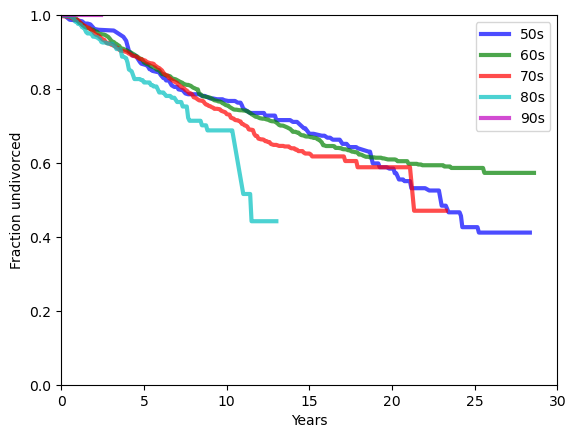

In [16]:
# Plot th survival function  for single iteration  based on decade cohorts
PredictAndResampleAndPlotDivorceCurve(sampl_list)

- Women born in 50s have divorced after 25 years of mariage
- Women born in 60s survived the divorce post women born in 50s
- Women born in 70's had their divorce early  at 20years of marriage
- Women born in 80s  had a divorce between 5 ad 10 years  ,  but there are no enough data 
- No enough data for women born in 90s to estimate the survival duration for divorce



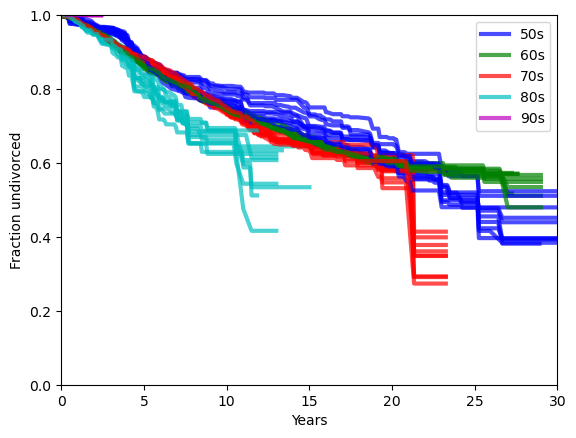

In [17]:
PredictAndResampleAndPlotDivorceCurve(sampl_list, Iters=10)

- Resampling and continuing multiple iterations show simillar patterns with minor deviations of approximately couple of years,  only 50s' and 80's born women data shows major deviation

In [18]:
#  Predict the values based on the cumulative hazard function
def PlotPredictionsByDecade(groups, **options):
    hfs = []
    for _, group in groups:
        hf, sf = EstimateSurvival(group)
        hfs.append(hf)

    thinkplot.PrePlot(len(hfs))
    for i, hf in enumerate(hfs):
        if i > 0:
            hf.Extend(hfs[i - 1])
        sf = hf.MakeSurvival()
        thinkplot.Plot(sf, color=colors[i])

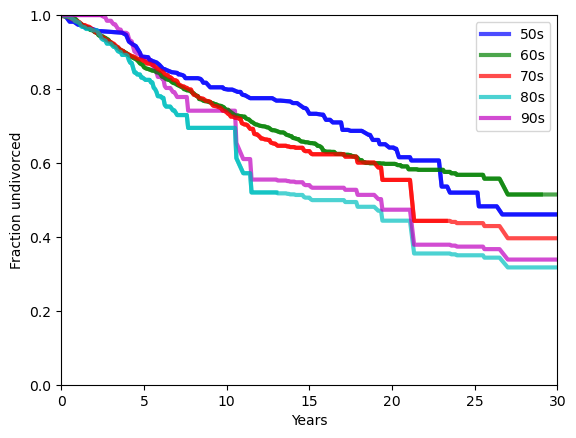

In [19]:
PredictAndResampleAndPlotDivorceCurve(sampl_list, pred_flg=True )

- The Predicted values show the 60s born women surviving the divorce upto 25+ years
- 70s and 50s born women  continue the same pattern in the predicted pattern as the orginal
- women born in 80s and 90s  have early divorce in 5 years abd 10 years and some of them survive post 20+ years
- Almost all of them converge between 25 and 30 years

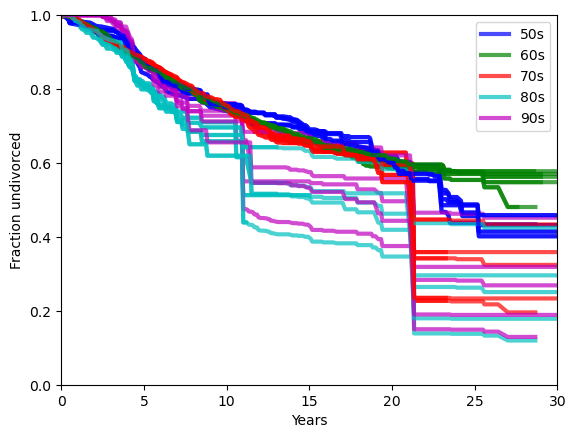

In [20]:
PredictAndResampleAndPlotDivorceCurve(sampl_list, pred_flg=True , Iters=5)

- Multiple iterations shows the same simillar patterns of deviations to single resamples data 